# ヴァイスシュヴァルツ ダメージシミュレーション
ダメージの通過をモンテカルロで試行し、試行回数のチューニングやヒストグラム出力まで行うノートブックです。


## アタックトリガーと効果ダメージの分離

攻撃ダメージ（ソウルトリガーが乗る可能性あり）と、トリガー処理を経由しない効果ダメージを `DamageEvent` で区別します。
ソウル+1トリガーを含めて攻撃解決を再現したい場合は、攻撃側の山札を表す `DeckConfig.attacking_deck_size` と `DeckConfig.attacking_soul_trigger_cards` を設定してください。


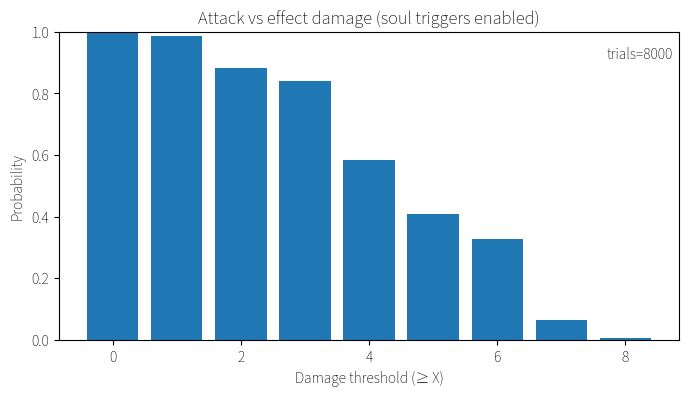

Trials used: 8000, mean damage=4.09, P(>=6)=0.327


In [5]:
from ws_sim.monte_carlo import DeckConfig, DamageEvent, simulate_trials, cumulative_probability_at_least, tune_trial_count
from ws_sim.plotting import plot_cumulative_histogram
import matplotlib.pyplot as plt

damage_sequence = [
    DamageEvent(base_damage=2, is_attack=True),
    DamageEvent(base_damage=1, is_attack=False),
    DamageEvent(base_damage=3, is_attack=True),
]

deck = DeckConfig(
    total_cards=50,
    climax_cards=8,
    attacking_deck_size=45,
    attacking_soul_trigger_cards=6,
)

chosen_trials, history = tune_trial_count(
    damage_sequence,
    deck,
    threshold=6,
    target_error=0.02,
    min_trials=500,
    seed=42,
)
damages = simulate_trials(damage_sequence, deck, trials=chosen_trials, seed=42)
thresholds = range(0, max(damages) + 1)
probabilities = cumulative_probability_at_least(damages, thresholds)

fig, ax = plot_cumulative_histogram(probabilities)
ax.set_title('Attack vs effect damage (soul triggers enabled)')
ax.text(0.99, 0.95, f'trials={chosen_trials}', transform=ax.transAxes, ha='right', va='top')
plt.show()
fig.savefig('../artifacts/damage_hist.png', bbox_inches='tight')

print(f'Trials used: {chosen_trials}, mean damage={sum(damages)/len(damages):.2f}, P(>=6)={probabilities.get(6, 0):.3f}')


## 途中リフレッシュを待機室事前投入でシミュレートする

ダメージシーケンス開始前にすでに待機室へ送られているカードを再現するため、`DeckConfig` の `waiting_room_cards` と `waiting_room_climax_cards` を使用します。
減った山札から引き込み、山札が尽きたら待機室をシャッフルして戻し、シーケンス中にそのシャッフルが起きた場合は自動でリフレッシュペナルティ1点を適用します。
これにより、意図的に圧縮した山札のラインを検証したり、リフレッシュタイミングがダメージカーブに与える影響を手軽に確認できます。



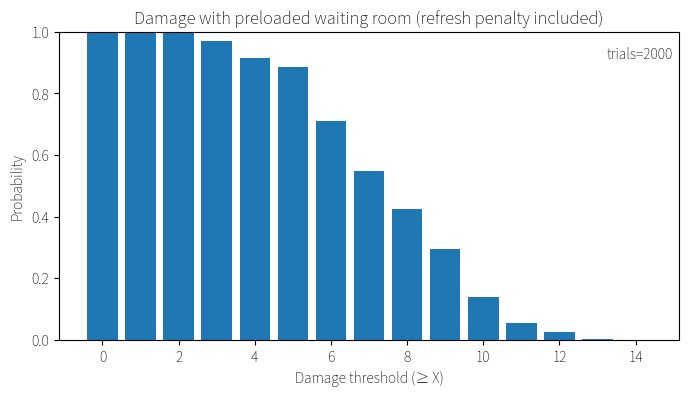

In [6]:
realistic_damage_sequence = [
    DamageEvent(base_damage=dmg)
    for dmg in (3, 2, 4, 3, 3, 4)
]

deck_with_waiting_room = DeckConfig(
    total_cards=50,
    climax_cards=8,
    waiting_room_cards=30,
    waiting_room_climax_cards=3,
)

mid_refresh_threshold = 7

chosen_trials_wr, history_wr = tune_trial_count(
    realistic_damage_sequence,
    deck_with_waiting_room,
    threshold=mid_refresh_threshold,
    target_error=0.02,
    min_trials=500,
    seed=7,
)

damages_with_refresh = simulate_trials(
    realistic_damage_sequence,
    deck_with_waiting_room,
    trials=chosen_trials_wr,
    seed=7,
)

thresholds_wr = range(0, max(damages_with_refresh) + 1)
probabilities_wr = cumulative_probability_at_least(damages_with_refresh, thresholds_wr)

fig_wr, ax_wr = plot_cumulative_histogram(probabilities_wr)
ax_wr.set_title("Damage with preloaded waiting room (refresh penalty included)")
ax_wr.text(0.99, 0.95, f'trials={chosen_trials_wr}', transform=ax_wr.transAxes, ha='right', va='top')
plt.show()

fig_wr.savefig('../artifacts/damage_hist_waiting_room.png', bbox_inches='tight')


## シード済みトップスタックによるメインフェイズ効果の再現

トップデッキの一部を固定しておくことで、過去のトリガーやミルで得た情報を反映した状態でメインフェイズの能力を処理できます。
`seeded_top_stack` のリストは山札の上から順に並べられており（``True`` = クライマックス）、ヘルパーがキャンセル可能なダメージが解決される前に山札を書き換えるため、その後のメインフェイズ処理やバトルアタックは調整済みの状態に対して行われます。
以下の例では、CXキャンセル時に4点を繰り返す条件付き4点ライン（初回4点が4点目でキャンセルされたときのみボーナス4点を追加）と、CX枚数をクロックに送る選択肢を比較し、そこで累積したダメージを保持したまま3回のバトルアタックに進んでいます。




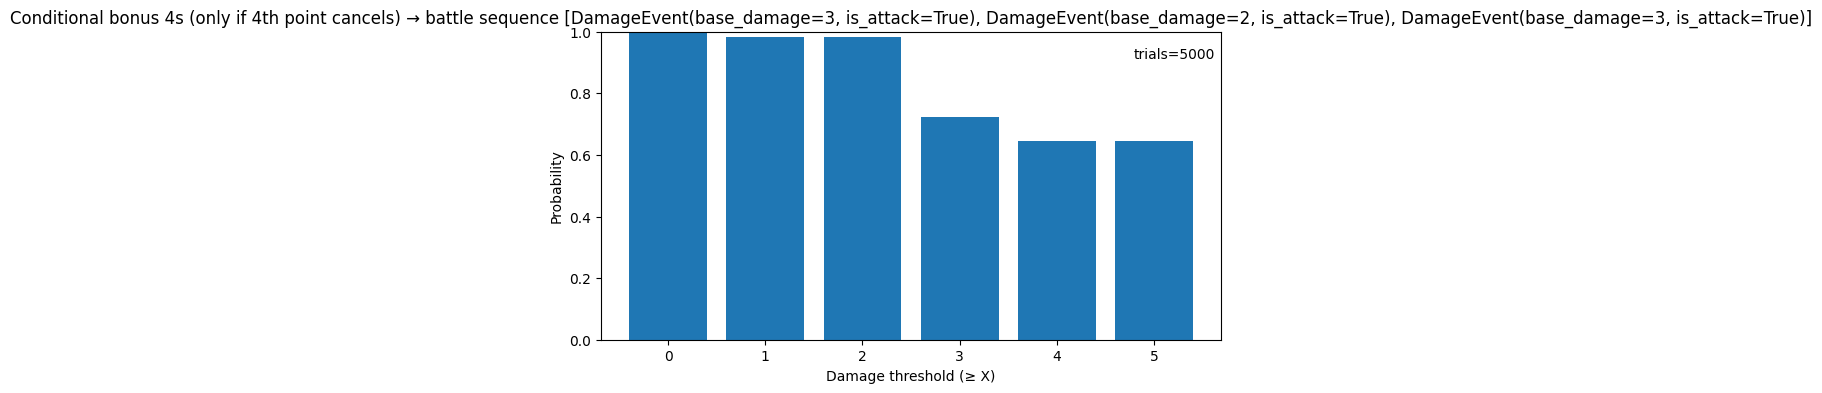

Conditional bonus 4s (only if 4th point cancels): mean=3.98, P(>=8)=0.000


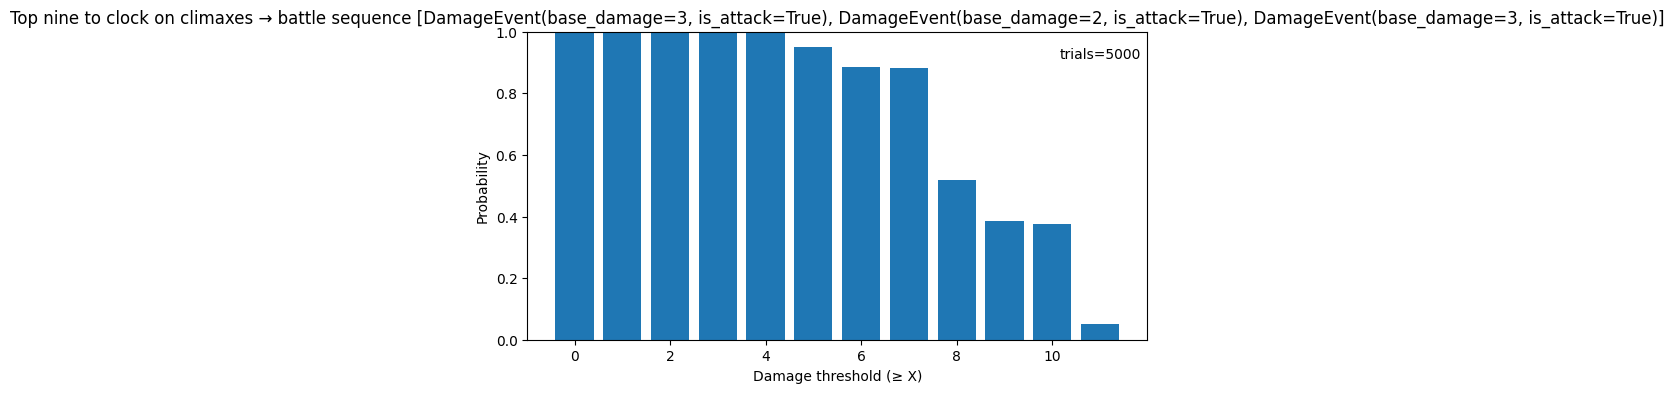

Top nine to clock on climaxes: mean=8.04, P(>=8)=0.520


In [7]:
from ws_sim.main_phase import apply_seeded_top_stack, run_main_phase_and_battle
from ws_sim.monte_carlo import (
    DamageEvent,
    DeckConfig,
    cumulative_probability_at_least,
    main_phase_fourth_cancel_bonus_damage,
    reveal_nine_clock_climaxes,
)
from ws_sim.plotting import plot_cumulative_histogram
import matplotlib.pyplot as plt

seeded_top_stack = [True, False, False, False, True, False, False, False]


battle_damage_sequence = [
    DamageEvent(base_damage=dmg)
    for dmg in (3, 2, 3)
]
seeded_deck = DeckConfig(
    total_cards=50,
    climax_cards=8,
    waiting_room_cards=12,
    waiting_room_climax_cards=3,
)

main_phase_lines = {
    "Conditional bonus 4s (only if 4th point cancels)": [
        apply_seeded_top_stack(seeded_top_stack),
        main_phase_fourth_cancel_bonus_damage,
    ],
    "Top nine to clock on climaxes": [
        apply_seeded_top_stack(seeded_top_stack),
        reveal_nine_clock_climaxes,
    ],
}

trial_count = 5000
for label, steps in main_phase_lines.items():
    damages = run_main_phase_and_battle(
        battle_damage_sequence,
        seeded_deck,
        main_phase_steps=steps,
        trials=trial_count,
        seed=2024,
    )
    thresholds = range(0, max(damages) + 1)
    probabilities = cumulative_probability_at_least(damages, thresholds)
    mean_damage = sum(damages) / len(damages)
    eight_plus = probabilities.get(8, 0)

    fig, ax = plot_cumulative_histogram(probabilities)
    ax.set_title(f"{label} → battle sequence {battle_damage_sequence}")
    ax.text(0.99, 0.95, f"trials={trial_count}", transform=ax.transAxes, ha="right", va="top")
    plt.show()
    fig.savefig(f"../artifacts/{label.split()[0].lower()}_seeded_stack.png", bbox_inches="tight")

    print(f"{label}: mean={mean_damage:.2f}, P(>=8)={eight_plus:.3f}")


## 魔石でストックを混ぜた後のアタック例

相手のストックと山札をまとめてシャッフルしてから同じ枚数のストックを積み直す魔石効果を `apply_magic_stone_effect` で再現します。
魔石による山札CX枚数のブレも含め、魔石処理→3点アタック×3回までを1トライアルとしてモンテカルロし、魔石未使用とのダメージ分布を比較します。


魔石後サンプル: 山札 24枚中CX 4枚 / ストック 8枚中CX 3枚


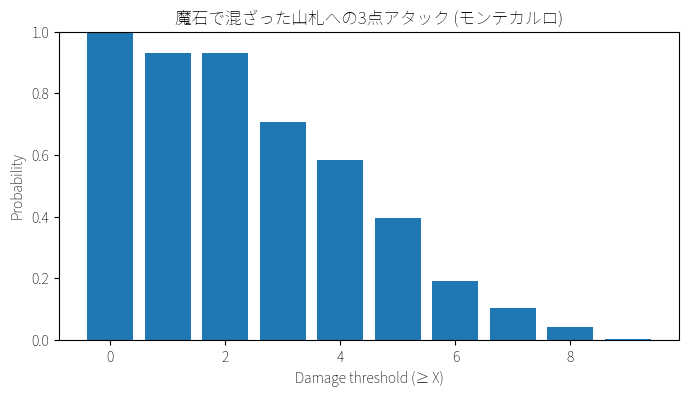

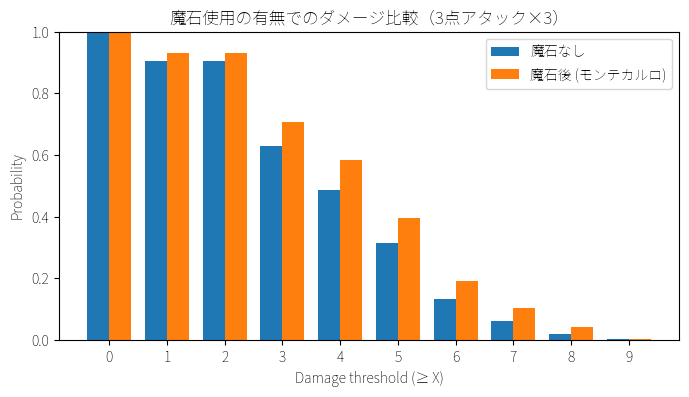

魔石なし: 平均3.45点
魔石あり: 平均3.89点


In [8]:
import random

from ws_sim.monte_carlo import (
    DamageEvent,
    DeckConfig,
    apply_magic_stone_effect,
    cumulative_probability_at_least,
    simulate_trials,
)
from ws_sim.plotting import plot_cumulative_histogram
import matplotlib.pyplot as plt
from matplotlib import font_manager

japanese_font_candidates = [
    "Noto Sans CJK JP",
    "Noto Sans JP",
    "IPAPGothic",
    "IPAexGothic",
    "Yu Gothic",
    "Hiragino Sans",
    "Meiryo",
]
available_fonts = {f.name for f in font_manager.fontManager.ttflist}
chosen_fonts = [name for name in japanese_font_candidates if name in available_fonts]
if chosen_fonts:
    plt.rcParams["font.family"] = chosen_fonts
    plt.rcParams["font.sans-serif"] = chosen_fonts
else:
    print("日本語フォントが見つからなかったためデフォルトを使用します。")
plt.rcParams["axes.unicode_minus"] = False

attack_sequence = [
    DamageEvent(base_damage=2),
    DamageEvent(base_damage=2),
    DamageEvent(base_damage=2),
]
TRIALS = 5000

def run_attacks(deck_config, *, trials=TRIALS, seed=314):
    damages = simulate_trials(
        attack_sequence,
        deck_config,
        trials=trials,
        seed=seed,
    )
    thresholds = range(0, max(damages) + 1)
    probabilities = cumulative_probability_at_least(damages, thresholds)
    return damages, probabilities

pre_magic_deck = DeckConfig(
    total_cards=24,
    climax_cards=6,
    attacking_soul_trigger_cards=10,
    attacking_deck_size=25,
)
pre_magic_damages, pre_magic_probabilities = run_attacks(pre_magic_deck)

def run_magic_stone_then_attack(*, trials=TRIALS, seed=314):
    rng = random.Random(seed)
    damages = []

    for _ in range(trials):
        magic_result = apply_magic_stone_effect(
            stock_cards=8,
            stock_climax_cards=1,
            deck_cards=24,
            deck_climax_cards=6,
            rng=rng,
        )

        deck_after_magic = DeckConfig(
            total_cards=magic_result.deck_cards,
            climax_cards=magic_result.deck_climax_cards,
            attacking_soul_trigger_cards=10,
            attacking_deck_size=25,
        )

        trial_seed = rng.randint(0, 2**32 - 1)
        trial_damage = simulate_trials(
            attack_sequence,
            deck_after_magic,
            trials=1,
            seed=trial_seed,
        )[0]
        damages.append(trial_damage)

    thresholds = range(0, max(damages) + 1)
    probabilities = cumulative_probability_at_least(damages, thresholds)
    return damages, probabilities

post_magic_damages, post_magic_probabilities = run_magic_stone_then_attack()
sample_magic = apply_magic_stone_effect(
    stock_cards=8,
    stock_climax_cards=1,
    deck_cards=24,
    deck_climax_cards=6,
    rng=random.Random(314),
)
print(
    f"魔石後サンプル: 山札 {sample_magic.deck_cards}枚中CX {sample_magic.deck_climax_cards}枚 / "
    f"ストック {sample_magic.stock_cards}枚中CX {sample_magic.stock_climax_cards}枚"
)

fig_magic, ax_magic = plot_cumulative_histogram(post_magic_probabilities)
ax_magic.set_title("魔石で混ざった山札への3点アタック (モンテカルロ)")
fig_magic.savefig("../artifacts/magic_stone_post_hist.png", bbox_inches="tight")
plt.show()

thresholds = sorted(set(pre_magic_probabilities) | set(post_magic_probabilities))
bar_width = 0.38

fig_compare, ax_compare = plt.subplots(figsize=(8, 4))
ax_compare.bar(
    [t - bar_width / 2 for t in thresholds],
    [pre_magic_probabilities.get(t, 0) for t in thresholds],
    width=bar_width,
    label="魔石なし",
)
ax_compare.bar(
    [t + bar_width / 2 for t in thresholds],
    [post_magic_probabilities.get(t, 0) for t in thresholds],
    width=bar_width,
    label="魔石後 (モンテカルロ)",
)
ax_compare.set_xlabel("Damage threshold (≥ X)")
ax_compare.set_ylabel("Probability")
ax_compare.set_ylim(0, 1)
ax_compare.set_xticks(list(thresholds))
ax_compare.set_title("魔石使用の有無でのダメージ比較（3点アタック×3）")
ax_compare.legend()
fig_compare.savefig("../artifacts/magic_stone_comparison.png", bbox_inches="tight")
plt.show()

print(
    f"魔石なし: 平均{sum(pre_magic_damages)/len(pre_magic_damages):.2f}点\n"
    f"魔石あり: 平均{sum(post_magic_damages)/len(post_magic_damages):.2f}点"
)
